In [7]:
!pip install pymystem3

In [1]:
import pandas as pd
import numpy as np
import gensim
import tqdm
from gensim.models import CoherenceModel

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem

import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\yupes\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
comments_df = pd.read_csv('D:\projects\Световая концепция\comments v2.csv')

C:\Users\yupes\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (4,7,19,24,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
comments_df = comments_df.loc[~comments_df.text.isna()]

In [19]:
comments_df[['normal_sentens']][:10]

,normal_sentens
0,санкт-петербургский станция аэрация
1,центральный станция аэрация
2,водоканал
3,классно
4,вы ещё стираит тайдом тогда мы идти к вы
5,простой смертный туда не попасть
6,производственный площадка
7,водоканал
8,зелёный территория вдоль улица володарский что...
9,я нравиться там гулять чисто и красиво


In [6]:
lem = Mystem()
nltk.download('stopwords')
stop = stopwords.words('russian')

def preprocess_text(x):
#     return [word.rstrip() for word in (''.join(lem.lemmatize(x))).split(' ') if (word not in stop and word != '')]
    return [word.rstrip() for word in x.split(' ') if (word not in stop and word != '')]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yupes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
stop.extend([
u'я', u'а', u'да', u'но', u'тебе', u'мне', u'ты', u'и', u'у', u'на', u'ща', u'ага',
u'так', u'там', u'какие', u'который', u'какая', u'туда', u'давай', u'короче', u'кажется', u'вообще',
u'ну', u'не', u'чет', u'неа', u'свои', u'наше', u'наш', u'весь', u'хотя', u'такое', u'например', u'кароч', u'как-то',
u'нам', u'хм', u'всем', u'нет', u'да', u'оно', u'своем', u'про', u'вы', u'м', u'тд',
u'вся', u'кто-то', u'что-то', u'вам', u'это', u'эта', u'эти', u'этот', u'прям', u'либо', u'как', u'мы',
u'просто', u'блин', u'очень', u'самые', u'твоем', u'ваша', u'кстати', u'вроде', u'типа', u'пока', u'ок',u'еще',u'ещё'
u'мочь'
])

In [20]:
text_data = comments_df['normal_sentens'].to_numpy()

text_data_lemmatized = []
for text in tqdm.tqdm_notebook(text_data):
    text_data_lemmatized.append(preprocess_text(text))

<ipython-input-20-56876b771f56>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for text in tqdm.tqdm_notebook(text_data):


In [14]:
len(comments_df.url.unique())

1234

In [21]:
comments_df['lines_lemmatized'] = text_data_lemmatized

In [31]:
comments_df['length'] = comments_df.lines_lemmatized.str.len()

In [32]:
comments_df.to_pickle('data.pkl')

In [33]:
stratified_data = []
for url in comments_df.url.unique():
#     print(comments_df[comments_df['url'].isin([url])])
    try:
        stratified_data.append(comments_df[comments_df['url'].isin([url])].sample(500))
    except:
        continue
stratified_data = pd.concat(stratified_data)
stratified_data.shape

(43500, 43)

In [34]:
data_words = stratified_data['lines_lemmatized'].to_numpy()

In [35]:
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [36]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in tqdm.notebook.tqdm(texts, leave=False)]

In [37]:
data_words_bigrams = make_bigrams(data_words)

In [38]:
id2word = gensim.corpora.Dictionary(data_words_bigrams)

In [39]:
print(f'Размер словаря до фильтрации: {len(id2word)}')

Размер словаря до фильтрации: 27695


In [40]:
id2word.filter_extremes(no_below=3, no_above=0.5)
print(f'Размер словаря после фильтрации: {len(id2word)}')

Размер словаря после фильтрации: 11036


In [41]:
# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tqdm.notebook.tqdm(texts, leave=False)]

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    
    Credits: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm.notebook.tqdm(range(start, limit, step)):
        
        model = gensim.models.ldamulticore.LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=42,
            chunksize=100,
            passes=10,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [43]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, 
    corpus=corpus, 
    texts=texts, 
    start=5, limit=55, step=5
)

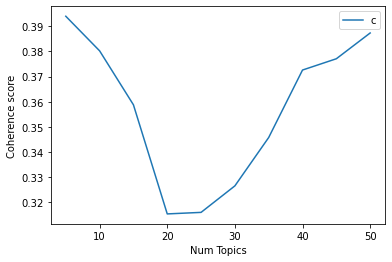

In [44]:
x = range(5, 55, 5)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
%%time
data_words = comments_df['lines_lemmatized'].to_numpy()

bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_words_bigrams = make_bigrams(data_words)
id2word = gensim.corpora.Dictionary(data_words_bigrams)
print(f'Размер словаря до фильтрации: {len(id2word)}')
id2word.filter_extremes(no_below=3, no_above=0.5)
print(f'Размер словаря после фильтрации: {len(id2word)}')

# Create Corpus
texts = data_words_bigrams
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tqdm.notebook.tqdm(texts, leave=False)]

Размер словаря до фильтрации: 52586
Размер словаря после фильтрации: 21417


Wall time: 16.5 s


In [46]:
%%time
final_model = gensim.models.ldamulticore.LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=10, 
            random_state=42,
            chunksize=100,
            passes=10,
        )

Wall time: 1min 47s


In [47]:
coherencemodel = CoherenceModel(model=final_model, texts=texts, dictionary=id2word, coherence='c_v')
coherencemodel.get_coherence()

0.44824566988288617

In [48]:
final_model.save('final_model_10_topics')
with open('corpus', 'wb') as f:
    pkl.dump(corpus, f)

In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns           
import umap

from tqdm.notebook import tqdm_notebook
from wordcloud import WordCloud

from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, AgglomerativeClustering

import pickle
import gensim
import matplotlib
%matplotlib inline

from utils import (
    plot_word_cloud, 
    get_umap_representation,
    plot_distortions,
    plot_dendrogram
)

In [50]:
# loading the model
model = gensim.models.LdaModel.load('final_model_10_topics')
topics = model.show_topics(num_topics=10, num_words=100, formatted=False)

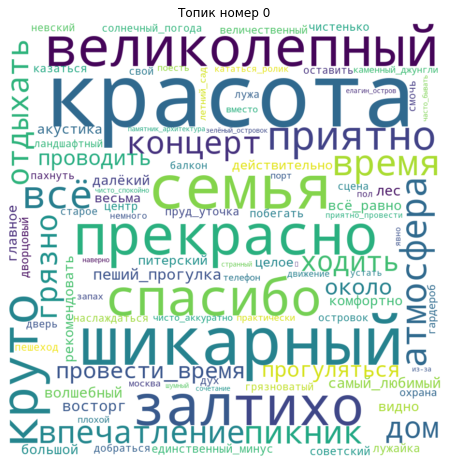

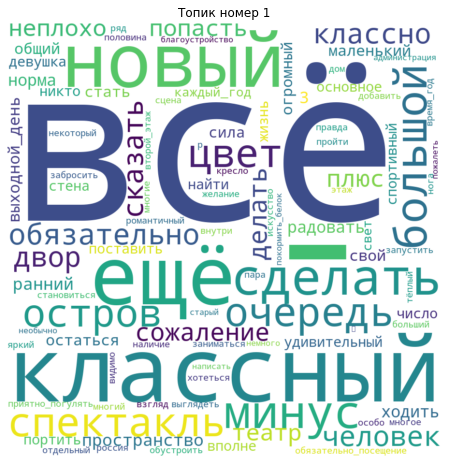

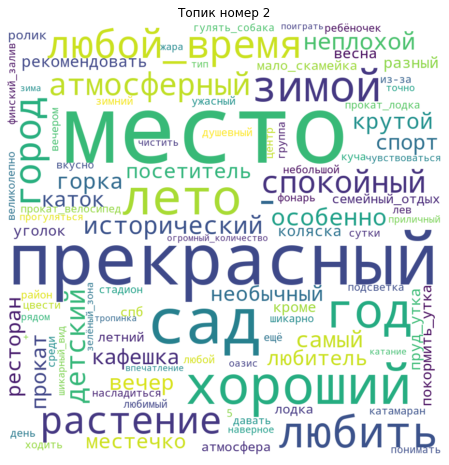

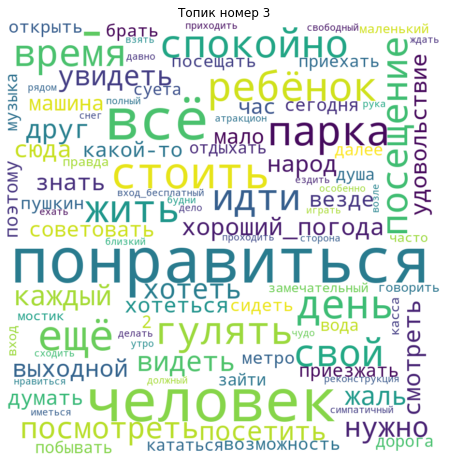

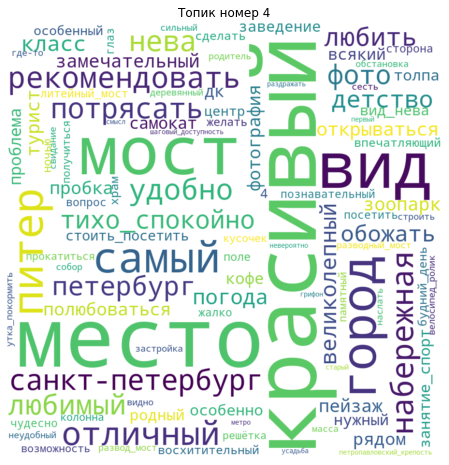

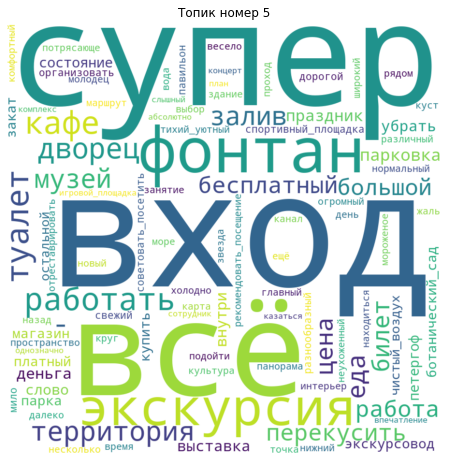

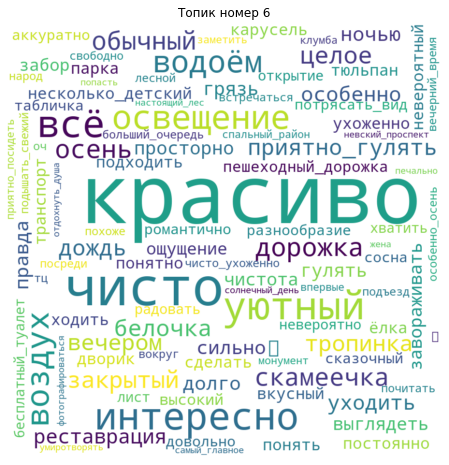

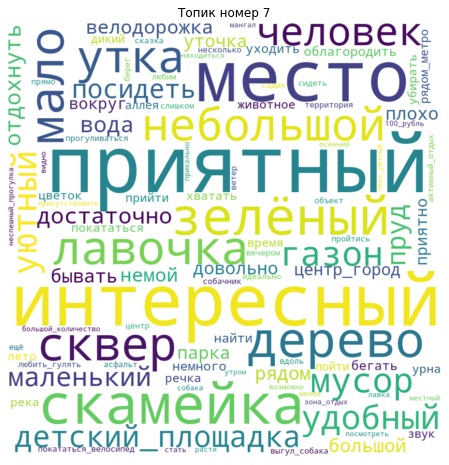

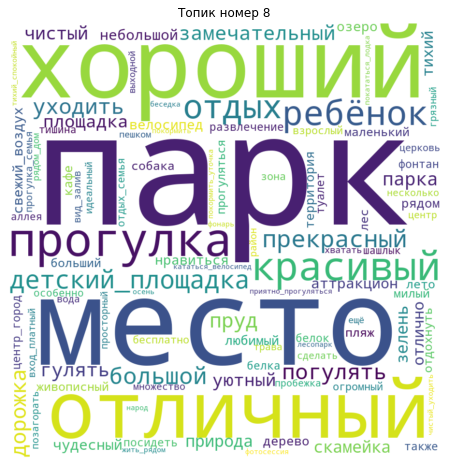

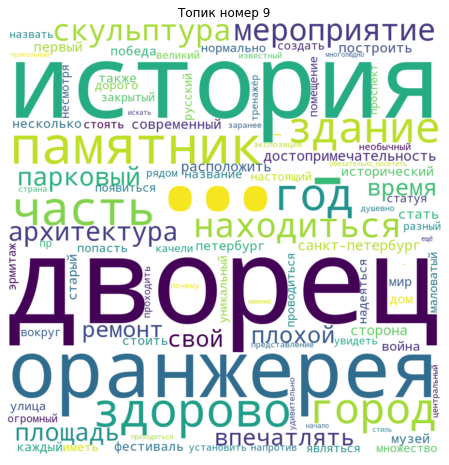

In [51]:
for topic_number in range(10):
    plot_word_cloud(topics, topic_number)